#### Energy Optimization of a 2D Truss Bridge

In [9]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import math as m
import pandas as pd
from scipy import optimize
import random as rdm

In [2]:
# SETUP: ADD INPUT PARAMETERS FOR METHODS 1 AND 2

# Select an average car mass and the number of cars driving on bridge at once
mcar = 1200 # [kg]
ncars = 6 # number of cars on bridge

# Select number of samples to generate (remember, the parameters are randomly selected each time)
nsamp = 5

In [3]:
## SECTION A: DEFINE FUNCTIONS

def beammass(): # Creates array of truss masses using randomly generated parameters
    N = np.array([2,4,2,5,5,2,4,2]) # number of beams connected to each mass
    mbeams = [] # all point masses in the truss [kg]
    for i in range(8):
        mbeams_i = N[i]*(1/2 * mu * L[rdm.randint(0,41)])
        mbeams.append(mbeams_i)
    return mbeams


def posmethod(points,method): # Generate 1D position array to use as input for CalcEnergy and optimizer
    # Convert the 8x2 matrix "points" to a 1D array, since the optimizer requires 1D
    # Delete the x- and/or y-values of p1, p2, p3, since they aren't being optimized (ground-fixed)
    if method == 1: # delete only y-vals
        pos = np.delete(np.matrix.flatten(points), [1,3,5]) 
    if method == 2: # delete x- and y-vals
        pos = np.delete(np.matrix.flatten(points), [0,1,2,3,4,5]) 
    return pos

def findconnections(points):
    connections = np.array([[points[0],points[1]],
                                [points[1],points[2]],
                                [points[0],points[3]],
                                [points[1],points[3]],
                                [points[1],points[4]],
                                [points[2],points[4]],
                                [points[3],points[4]],
                                [points[3],points[5]],
                                [points[3],points[6]],
                                [points[4],points[6]],
                                [points[4],points[7]],
                                [points[5],points[6]],
                                [points[6],points[7]]])
    return connections

def CalcEnergy(pos, k, L, mbeams, mcar, ncars, method):
    
    g=9.81
    
    if method ==1:
        # converts 1D input array back to 2D matrix for convenience
        points=np.insert(pos, [1,2,3], [0,0,0]).reshape(8,2) # re-insert y-vals of bottom 3 points
    if method ==2:
        points=np.insert(pos, 0, [0,0,1,0,2,0]).reshape(8,2) # re-insert x- and y-vals of bottom 3 points

    connections = findconnections(points)
        
    E_grav = 0.
    for i in range(5): # Addresses the bottom 5 points
        E_grav += mbeams[i]*g*points[i,1]
        
    for i in range(6,8): # Addresses the top 3 points and accounts for uniformly-distributed mass of cars driving on top
        E_grav += (mbeams[i]+mcar*ncars)*g*points[i,1]

    E_elas = 0.
    for i in range(13): # 13 total connections AKA beams
        dist_i = np.sqrt(np.sum((connections[i,0]-connections[i,1])**2))
        E_elas += 0.5 * k * (dist_i-L)**2

    E_total = E_grav + E_elas
    
    return E_total


def energyArrays(nsamp,pos,k,L,mbeams,mcar,ncars,method): # Create arrays of outputs from CalcEnergy before and after optimization
    E_original = [] # n samples of non-optimized energy outputs
    E_opt = [] # n samples of optimized energy outputs
    for i in range(nsamp):
        rdm_indx = rdm.randint(0,41)
        minimized = optimize.minimize(CalcEnergy,pos, args=(k[rdm_indx], L[rdm_indx], mbeams, mcar, ncars,method), tol=0.1)
        E_original_i = CalcEnergy(pos, k[rdm_indx], L[rdm_indx],mbeams, mcar, ncars,method)
        E_opt_i = minimized.fun
        E_original.append(E_original_i)
        E_opt.append(E_opt_i)
    return E_original, E_opt, minimized

def pointsopt(minimized, method): # Fills the optimal points into an array
    
    pos_opt = minimized.x
    if method == 1:
        points_opt = np.insert(pos_opt, [1,2,3], [0,0,0]).reshape(8,2) # re-insert y-vals of bottom 3 points
    if method == 2:
        points_opt = np.insert(pos_opt, 0, [0,0,1,0,2,0]).reshape(8,2) # re-insert x- and y-vals of bottom 3 points
    
    return points_opt

def plotter(points, points_opt, E_original, E_opt, method): # Creates position scatter plots and energy histograms
    
    plt.scatter(points[:,0],points[:,1],color='blue', s =100) # Original mass positions
    plt.scatter(points_opt[:,0],points_opt[:,1],color='red', s =100) # Optimized mass positions (example; 1 sample)
    plt.title('Truss Position (Method %i)' %method)
    plt.xlabel("X-Position [m]")
    plt.ylabel("Y-Position [m]")
    plt.legend(['Original','Optimal'], loc=0)
    plt.show()      

    # Distribution of total truss energy before optimization (with randomly-generated input parameters)
    plt.hist(E_original,rwidth=0.8,bins=15)
    plt.title('Total Truss Energy Before Optimization (Method %i)' %method)
    plt.xlabel("Total Energy [J]")
    plt.ylabel("Number of Occurences")
    plt.show()

    # Distribution of total truss energy after optimization (with randomly-generated input parameters)
    plt.hist(E_opt,rwidth=0.8,bins=15)
    plt.title('Total Truss Energy After Optimization (Method %i)' %method)
    plt.title('Total Truss Energy After Optimization (Method %i)' %method)
    plt.xlabel("Total Energy [J]")
    plt.ylabel("Number of Occurences")
    plt.show()
    
    return

def failuretest(points,points_opt,L,ultstrain,ncars,mcar):
    connections_opt = findconnections(points_opt)
    act_strain = []
    for i in range(13):
        L0 = np.mean(L)
        L_opt = np.sqrt(np.sum((connections_opt[i,0]-connections_opt[i,1])**2))
        act_strain_i = abs((L_opt-L0)/L0)
        act_strain.append(act_strain_i)

    if all(ultstrain>max(act_strain)):
        print("Actual strain (mean = %.2e, max = %.2e) < ultimate strain (mean = %.2e, max = %.2e) in every beam, so the structure will not fail." 
              %(np.mean(act_strain), max(act_strain), np.mean(ultstrain),max(ultstrain)));
        print("Elastonium is therefore a suitable building material under %i cars which weigh %.2f kg each (%.2f kg total)." %(ncars,mcar,ncars*mcar))
    else:
        print("Actual strain (mean = %.2e, max = %.2e) > ultimate strain (mean = %.2e, max = %.2e) in one or more beams, so the structure will fail." 
              %(np.mean(act_strain), max(act_strain), np.mean(ultstrain),max(ultstrain)));
        print("Elastonium is therefore an unsuitable building material under %i cars which weigh %.2f kg each (%.2f kg total)." %(ncars,mcar,ncars*mcar))
    return


In [4]:
## SECTION B: DETERMINE TRUSS/BRIDGE MATERIAL PARAMETERS

data1 =np.array(pd.read_csv('length-data.csv'))
data2 =np.array(pd.read_csv('stress-strain-data.csv'))

do = 50e-3 # outer tube diameter [m]
di = 40e-3 #inner tube diameters [m]
A = np.pi*(do**2-di**2)/4 #tube area [m2]
rho = 7000 # density of tube material [kg/m3]
mu = rho*A # length normalized density for elastic connections [kg/m]
g = 9.81 # [m/s2]


stress = np.array(data2[4:,1:],dtype=float)*10e6 # [Pa]
strain = np.array(data2[4:,0],dtype=float) # [-]
L = data1[:,1] 

youngsmod = [] # Young's Modulus [GPa]
uts = [] # ultimate tensile strength [Pa]
ultstrain=[] # Ultimate strain [-]
k = [] # spring constant [N/m] 

for i in range(42):

    youngsmod_i = np.mean(np.divide(stress[1:12,i], strain[1:12]))/10e9 # Young's Modulus [GPa]
    youngsmod.append(youngsmod_i)

    uts_i = np.amax(stress[:,i])
    uts.append(uts_i)

    uts_indx = int(np.where((stress[:,i]==uts[i]))[0])
    ultstrain_i =  strain[uts_indx]
    ultstrain.append(ultstrain_i)

    k_i = youngsmod_i*10e9*A/L[i]
    k.append(k_i)

#Print useful parameter info
print("The average length of a beam is",np.mean(L),"m")
print("The linear density is",mu, "kg/m")
print("The average Young's Modulus is",np.mean(youngsmod), "GPa")
print("The average ultimate tensile strength is",np.mean(uts),"Pa")
print("The average ultimate strain is",np.mean(ultstrain))
print("The average spring constant is",np.mean(k),"N/m")

The average length of a beam is 0.9987500000000001 m
The linear density is 4.948008429403926 kg/m
The average Young's Modulus is 0.36045171907571194 GPa
The average ultimate tensile strength is 177055006.86190477 Pa
The average ultimate strain is 0.049489795904761893
The average spring constant is 2551220.304251831 N/m


In [5]:
## SECTION C: CONSTRUCT MATRIX OF ORIGINAL TRUSS MASS POSITIONS
ang = np.pi/3
points = np.array([[0., 0.],
                   [1.,0.],
                   [2., 0.],
                   [(np.cos(ang)), (np.sin(ang))],
                   [1.+np.cos(ang), np.sin(ang)],
                   [0., 2.*np.sin(ang)],
                   [1., 2.*np.sin(ang)],
                   [2., 2.*np.sin(ang)]])

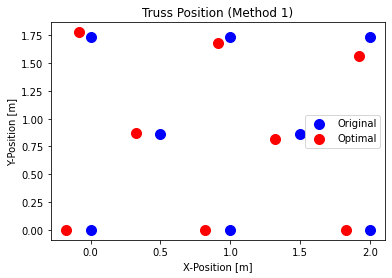

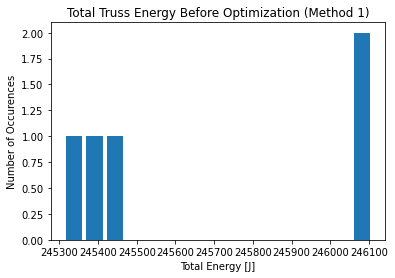

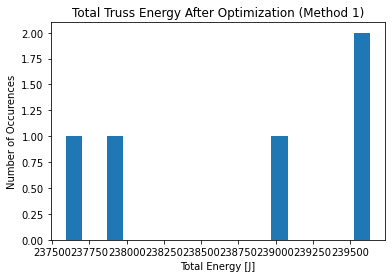

Actual strain (mean = 1.64e-02, max = 4.24e-02) > ultimate strain (mean = 4.95e-02, max = 6.43e-02) in one or more beams, so the structure will fail.
Elastonium is therefore an unsuitable building material under 6 cars which weigh 1200.00 kg each (7200.00 kg total).


In [6]:
## SECTION D: OPTIMIZE ENERGY (METHOD 1: POINTS 1, 2, 3 GROUND-FIXED IN THE Y-DIRECTION ONLY)

# Choose method (1 or 2)
method = 1

# Generate array of truss masses using randomly generated parameters
mbeams = beammass()

# Generate 1D position array to use as input for CalcEnergy and optimizer
pos = posmethod(points,method)

# Obtain energy arrays before and after optimization
E_original = energyArrays(nsamp,pos,k,L,mbeams,mcar,ncars,method)[0]
E_opt = energyArrays(nsamp,pos,k,L,mbeams,mcar,ncars,method)[1]

# Obtain optimal position values from the built-in minimizer
minimized = energyArrays(nsamp,pos,k,L,mbeams,mcar,ncars,method)[2]
points_opt = pointsopt(minimized, method)

# Plot positions of truss masses before and after optimization
plotter(points,points_opt,E_original,E_opt,method) # generates position plot and energy histograms

# Will the bridge fail under an external load of ncars*mcar [kg]?
failuretest(points,points_opt,L,ultstrain,ncars,mcar)

# NOTE: this cell will take awhile to run because of the large sample size

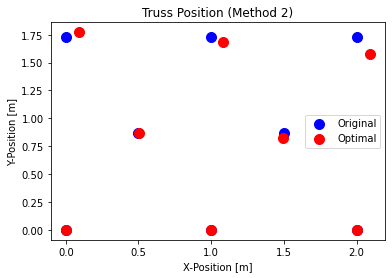

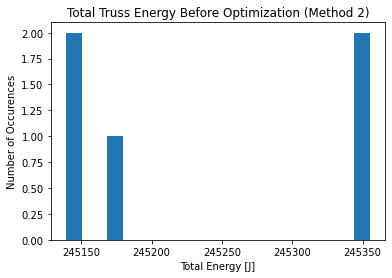

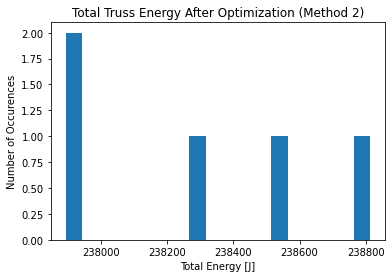

Actual strain (mean = 1.46e-02, max = 4.13e-02) > ultimate strain (mean = 4.95e-02, max = 6.43e-02) in one or more beams, so the structure will fail.
Elastonium is therefore an unsuitable building material under 6 cars which weigh 1200.00 kg each (7200.00 kg total).


In [7]:
## SECTION E: OPTIMIZE ENERGY (METHOD 2: POINTS 1, 2, 3 GROUND-FIXED IN THE X- AND Y-DIRECTIONS)

# Choose method (1 or 2)
method = 2

# Generate array of truss masses using randomly generated parameters
mbeams = beammass()

# Generate 1D position array to use as input for CalcEnergy and optimizer
pos = posmethod(points,method)

# Obtain energy arrays before and after optimization
E_original = energyArrays(nsamp,pos,k,L,mbeams,mcar,ncars,method)[0]
E_opt = energyArrays(nsamp,pos,k,L,mbeams,mcar,ncars,method)[1]

# Obtain optimal position values from the built-in minimizer
minimized = energyArrays(nsamp,pos,k,L,mbeams,mcar,ncars,method)[2]
points_opt = pointsopt(minimized, method)

# Plot positions of truss masses before and after optimization
plotter(points,points_opt,E_original,E_opt,method) # generates position plot and energy histograms

# Will the bridge fail under a load of n cars which weigh mcar [kg] each?
failuretest(points,points_opt,L,ultstrain,ncars,mcar)

# NOTE: this cell will take awhile to run because of the large sample size

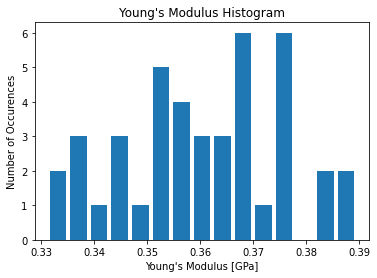

Linear Regression Results: LinregressResult(slope=-1.0858097955850212, intercept=1.444904252416252, rvalue=-0.2728899923813432, pvalue=0.08037491201766807, stderr=0.6052456092128511, intercept_stderr=0.6044934370868857)


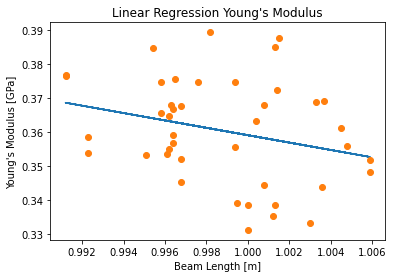

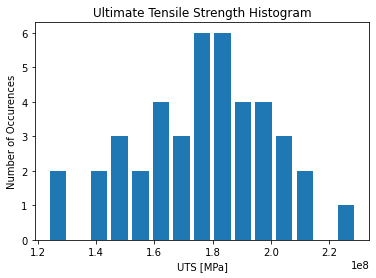

LinregressResult(slope=285461314.64860916, intercept=-108049481.14339367, rvalue=0.04792190623971805, pvalue=0.7631323096631543, stderr=940771011.2360874, intercept_stderr=939601863.1732236)


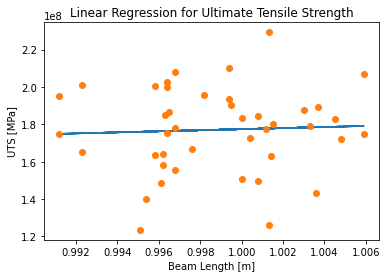

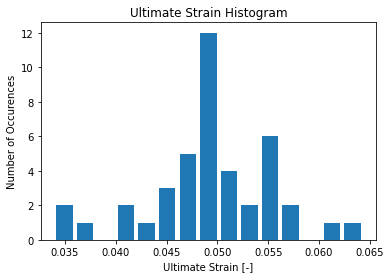

LinregressResult(slope=0.215059592961556, intercept=-0.16530097256559217, rvalue=0.1321805796220635, pvalue=0.40402936848187454, stderr=0.2549961977917855, intercept_stderr=0.25467929994191)


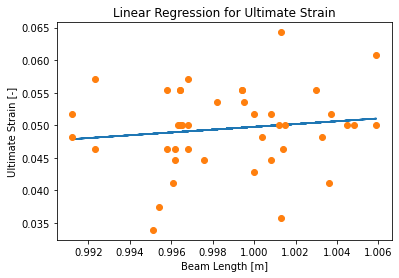

In [8]:
## SECTION F: STATISTICAL ANALYSIS OF SECTION B PARAMETERS

# Distribution of Young's Modulus samples
plt.hist(youngsmod,rwidth=0.8,bins=15)
plt.title("Young's Modulus Histogram")
plt.xlabel("Young's Modulus [GPa]")
plt.ylabel("Number of Occurences")
plt.show()

# Analyzing length vs. Young's Modulus
linear_R1=stats.linregress(L,youngsmod)
print('Linear Regression Results:',linear_R1)
m,b=np.polyfit(L,youngsmod,1)
plt.plot(L,(m*L+b))
plt.plot(L,youngsmod,'o')
plt.title("Linear Regression Young's Modulus")
plt.xlabel("Beam Length [m]")
plt.ylabel("Young's Modulus [GPa]")
plt.show()

# Distribution of UTS samples
plt.hist(uts,rwidth=0.8,bins=15,)
plt.title('Ultimate Tensile Strength Histogram')
plt.xlabel('UTS [MPa]')
plt.ylabel("Number of Occurences")
plt.show()

# Analyzing length vs. UTS
linear_R2=stats.linregress(L,uts)
print(linear_R2)
m,b=np.polyfit(L,uts,1)
plt.plot(L,(m*L+b))
plt.plot(L,uts,'o')
plt.title('Linear Regression for Ultimate Tensile Strength')
plt.xlabel("Beam Length [m]")
plt.ylabel("UTS [MPa]")
plt.show()

# Distribution of ultimate strain samples
plt.hist(ultstrain,rwidth=0.8,bins=15)
plt.title('Ultimate Strain Histogram')
plt.xlabel('Ultimate Strain [-]')
plt.ylabel("Number of Occurences")
plt.show()

# Analyzing length vs. ultimate strain
linear_R3=stats.linregress(L,ultstrain)
print(linear_R3)
m,b=np.polyfit(L,ultstrain,1)
plt.plot(L,(m*L+b))
plt.plot(L,ultstrain,'o')
plt.title('Linear Regression for Ultimate Strain')
plt.xlabel("Beam Length [m]")
plt.ylabel("Ultimate Strain [-]")
plt.show()